In [18]:
import pickle, os, glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize
from matplotlib.patches import Rectangle
from scipy.special import erf

In [19]:
path = "D:/data/SiPM/waveforms/20240521/ba133"
filename_list = ["Ba133_28V_x0.0_y0.0_*.pkl",] 
save_str = ["Ba133",]
ov_list = [28,]
data_time = [10, ] ## acquisition time in seconds

In [20]:
ovs_dict = {}

fsample = 62.5e6 ## sampling rate in Hz
record_length = 129 ## not clear why this differs from the 128 set above
time_vec = np.arange(0, record_length/fsample, 1/fsample)

for j,filename in enumerate(filename_list):
    
    curr_files = glob.glob(os.path.join(path, filename))
    
    data_dict = {}

    wfidx = 0
    for cidx, cf in enumerate(curr_files):
        
        with open(cf, 'rb') as fin:
            curr_dict = pickle.load(fin)

            for wf in curr_dict:

                sum_waveform = np.zeros_like(time_vec)	
                
                ## subtract baseline
                baseline = 2048 

                channel_dict = {}
                for k, ch in enumerate(range(16,-1,-2)):
                    channel_dict[k] = wf[ch] - baseline
                    sum_waveform += (wf[ch] - baseline)

                channel_dict[9] = sum_waveform

                data_dict[wfidx] = channel_dict
                wfidx += 1

    nwaveforms = wfidx
    print("Got %d waveforms"%nwaveforms + " for %d files: "%len(curr_files) + filename)
    data_dict['time'] = time_vec*1e9

    ovs_dict[ov_list[j]] = {'nwaveforms': nwaveforms, 'data_dict': data_dict}

Got 196416 waveforms for 192 files: Ba133_28V_x0.0_y0.0_*.pkl


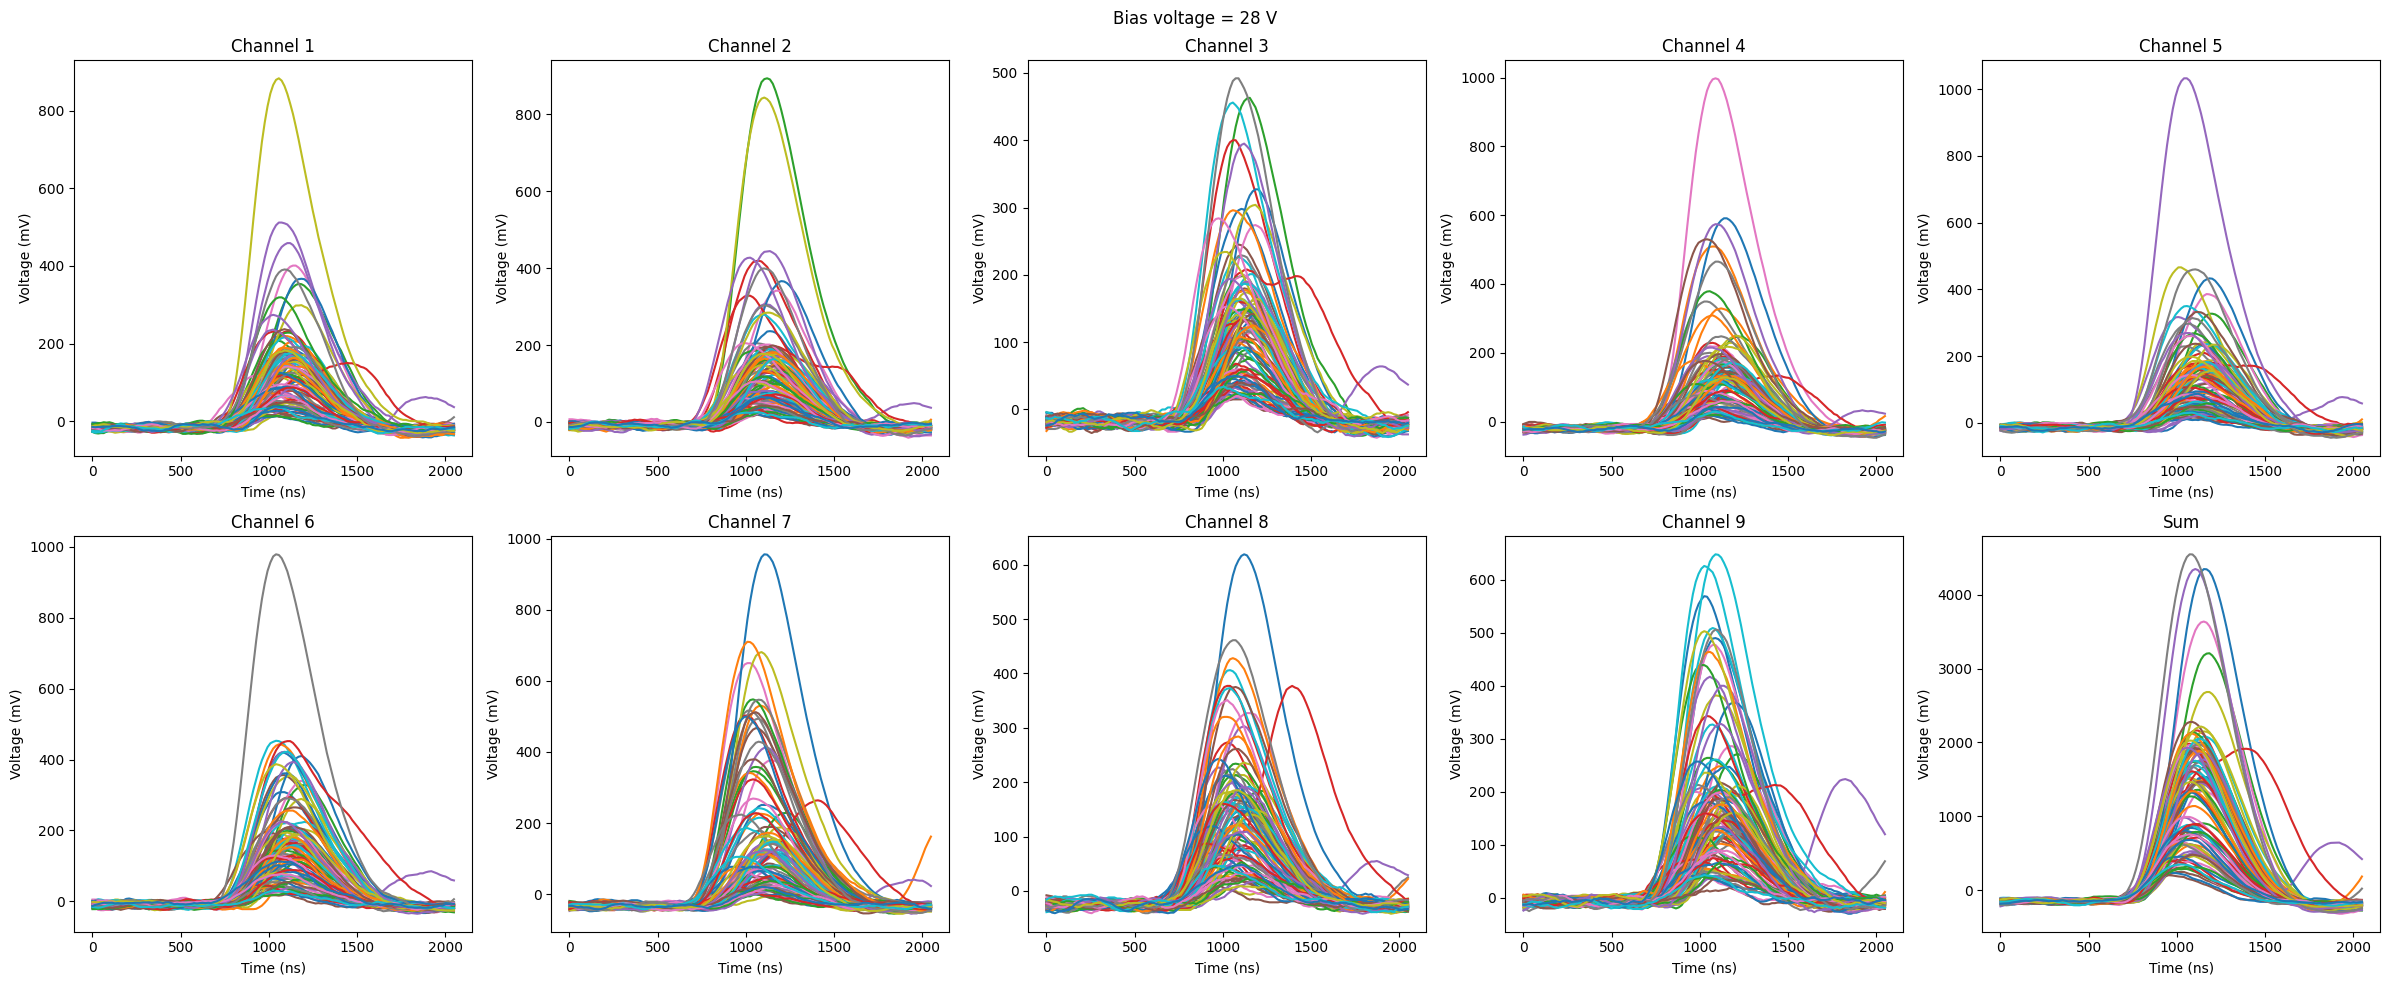

In [21]:
make_plot = True
max_figs = 100

for ov in ov_list:

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    if(nwaveforms > max_figs):
        downsamp = int(nwaveforms/max_figs)
    else:
        downsamp = 1

    if(make_plot):

        plt.figure(figsize=(24,10))

        for j in range(nwaveforms):
            if(j%downsamp != 0): continue

            for ch in range(10):
                plt.subplot(2,5,ch+1)
                plt.plot(data_dict['time'], data_dict[j][ch])
                plt.xlabel('Time (ns)')
                plt.ylabel('Voltage (mV)')
                if(ch < 9):
                    plt.title("Channel %d"%(ch+1))
                else:
                    plt.title("Sum")

        plt.suptitle("Bias voltage = %s V"%str(ov))
    plt.tight_layout()


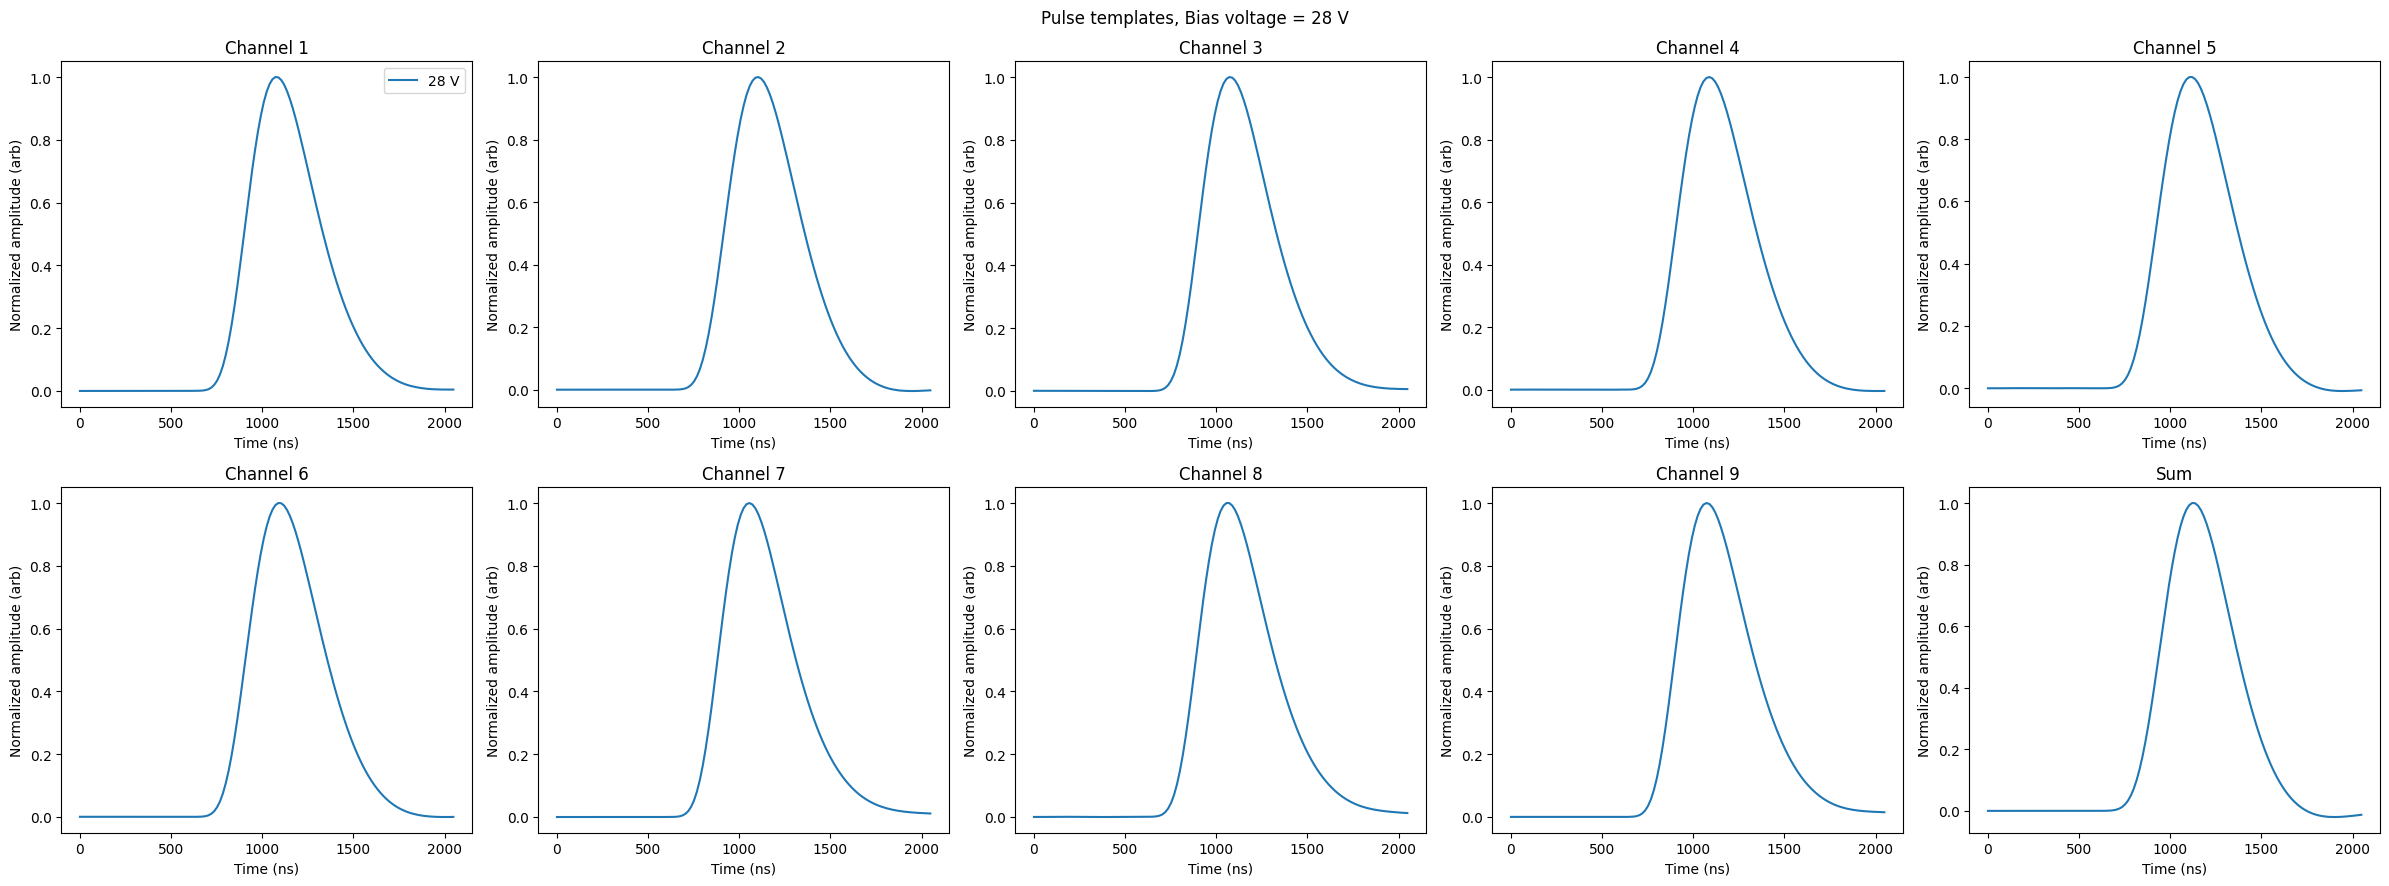

In [22]:
template_ch_dict = {}

min_vals = [500, 2000]

for ov in ov_list:

    plt.figure(figsize=(24,9))

    nwaveforms = ovs_dict[ov]['nwaveforms']
    data_dict = ovs_dict[ov]['data_dict']

    ## make average template
    template_dict = {}
    nwfm = np.zeros(10)
    for ch in range(10):
        template_dict[ch] = np.zeros(len(data_dict['time']))

    for j in range(nwaveforms):

        cdat = data_dict[j]

        for ch in range(10):

            ## throw out bad traces
            min_val = min_vals[0] if ch < 9 else min_vals[1]
            if np.max(cdat[ch]) < min_val:
                continue

            template_dict[ch] += cdat[ch]
            nwfm[ch] += 1

    for ch in range(10):
        plt.subplot(2,5,ch+1)
        template_dict[ch] /= nwfm[ch]
        template_dict[ch] -= np.median(template_dict[ch][:20])
        template_dict[ch] /= np.max(template_dict[ch])

        plt.plot(data_dict['time'], template_dict[ch], label="%s V"%str(ov))
        plt.xlabel('Time (ns)')
        plt.ylabel('Normalized amplitude (arb)')

        if(ch < 9):
            plt.title("Channel %d"%(ch+1))
        else:
            plt.title("Sum")

    template_ch_dict[ov] = template_dict

    plt.suptitle("Pulse templates, Bias voltage = %s V"%str(ov))
    plt.subplot(2,5,1)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [23]:
def gauss(x, A, mu, sig):
    return A*np.exp(-(x-mu)**2/(2*sig**2))

In [24]:
remake_files = True

tscan = 500 ## time to scan around the template in ns
pts_to_scan = int(tscan*1e-9 * fsample * 0.5)
print("scanning +/-%d points"%pts_to_scan)

for oidx, ov in enumerate(ov_list):

    if(remake_files):

        window  = [800, 1300]

        data_dict = ovs_dict[ov]['data_dict']

        mpts = (data_dict['time'] > window[0]) & (data_dict['time'] < window[1])

        recon_amps_max = []   
        recon_amps_fit = []   
          
        for k in data_dict.keys():
            if k == 'time': continue

            cdat_dict = data_dict[k]
            
            channel_max = np.zeros(10)
            channel_fit = np.zeros(10)
            for ch in range(10):

                cdat = cdat_dict[ch]

                shortened_temp = template_ch_dict[ov][ch][pts_to_scan:-pts_to_scan]

                #fit = np.sum( cdat*template_ch_dict[ov][ch] ) / np.sum(template_ch_dict[ov][ch]**2)
                fit_all = np.correlate(cdat, shortened_temp) / np.sum(shortened_temp**2)
                fit = np.max(np.abs(fit_all))

                midx = np.argmax(np.abs(cdat[mpts]))
                max_val = cdat[mpts][midx]
                
                channel_max[ch] = max_val
                channel_fit[ch] = fit
            
            recon_amps_max.append(channel_max)
            recon_amps_fit.append(channel_fit)

        recon_amps_max = np.array(recon_amps_max)
        recon_amps_fit = np.array(recon_amps_fit)

        np.savez( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)), recon_amps_max=recon_amps_max, 
                                                                                  recon_amps_fit=recon_amps_fit,
                                                                                  nwaveforms=nwaveforms)

    

scanning +/-15 points


In [25]:
# constants needed
m_e = 511 ## electron mass in keV
thickness = 1*np.sqrt(2) ## cm
density = 1 ## g/cm^3

In [26]:
### isotope data
## energy [keV]    Intensity    Compton [cm^2/g]     PE [cm^2/g]    type
ba_133_data = [[81, 0.329, 0.166, 1.9e-3, 1, 'gamma'],
               [276, 0.072, 0.119, 3.52e-5, 2, 'gamma'],
               [303, 0.18, 0.115, 2.65e-5, 3, 'gamma'],
               [356, 0.62, 0.108, 1.63e-5, 4, 'gamma'],
               [384, 0.089, 0.105, 1.31e-5, 5, 'gamma']]

In [27]:
def expected_spectrum(E, A, sigma, cal, iso_data=ba_133_data, lines=None):

    spectrum_out = np.zeros_like(E)
    cal_E = cal*E
    for rad in iso_data:

        if(lines):
            if rad[4] not in lines: 
                continue

        if(rad[-1] == 'gamma'):
            ## first add the compton
            compton_edge = rad[0] * (1 - 1/(1 + 2*rad[0]/m_e))
            spectrum_out += A*rad[1]/compton_edge * (1 - np.exp(-thickness * (rad[2] * density))) * (1-erf((cal_E-compton_edge)/(np.sqrt(2)*sigma)))

            ## now the photoelectric
            spectrum_out += 2*np.pi*A*rad[1]*(1 - np.exp(-thickness * (rad[3] * density)))/(np.sqrt(2*np.pi)*sigma) * np.exp(-(cal_E-rad[0])**2/(2*sigma**2))

    return spectrum_out

[1.98224494e+04 6.37567684e+00 5.97042072e-01]


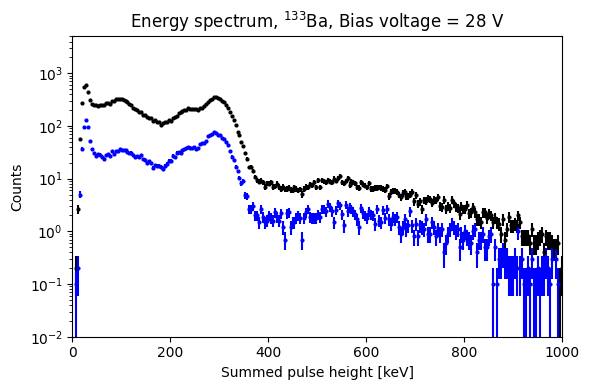

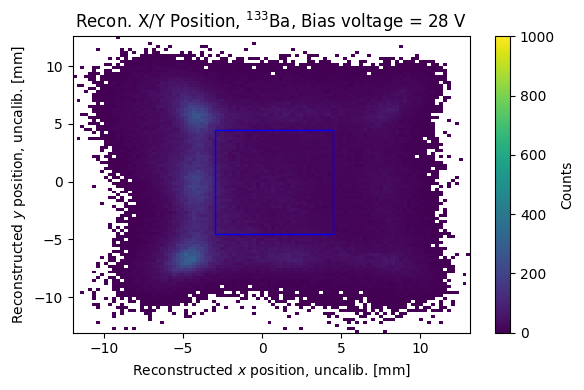

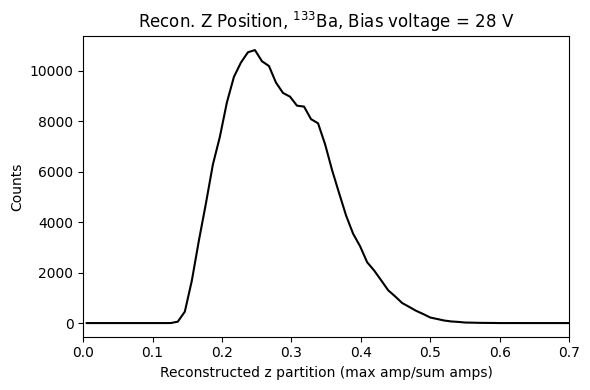

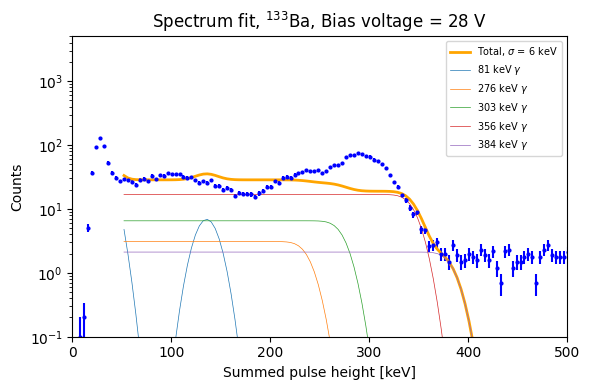

In [30]:
## plot and fit
save_figs = True

sipm_coords_x = np.array([-6.5, 0, 6.5, -6.5, 0, 6.5, -6.5, 0, 6.5])
sipm_coords_y = np.array([6.5, 6.5, 6.5, 0, 0, 0, -6.5, -6.5, -6.5])

cal_type_list = ['channel cal']

eng_fig = plt.figure(figsize=(6, 4))
pos_fig = plt.figure(figsize=(6, 4))
z_fig = plt.figure(figsize=(6, 4))
fit_fig = plt.figure(figsize=(6, 4))

xy_cal_fac = 3

for oidx, ov in enumerate(ov_list):

    data = np.load( os.path.join(path, "recon_amps_%s_%s.npz"%(save_str[oidx],ov)) )
    recon_amps_max = data['recon_amps_max']
    recon_amps_fit = data['recon_amps_fit']
    nwaveforms = data['nwaveforms']

    bins = np.linspace(0, 10000, 400)
    bc = bins[:-1] + np.diff(bins)

    norm = data_time[oidx]

    fit_amps = recon_amps_fit[:,9]
    h_fit, be = np.histogram( fit_amps, bins=bins )

    fpts = bc > 2000

    errs = np.sqrt(h_fit[fpts])
    errs[errs==0] = 1
    spars = [np.max(h_fit), np.median(fit_amps), np.std(fit_amps)]
    gc_fit = spars

    eng_cal_fac_fit = 0.16 #am241_alpha_eng/np.abs(gc_fit[1])

    amps = recon_amps_fit
    recon_x = (amps[:,:9] @ sipm_coords_x.T)/np.sum(amps[:,:9], axis = 1)
    recon_y = (amps[:,:9] @ sipm_coords_y.T)/np.sum(amps[:,:9], axis = 1)
    recon_z = np.max(np.abs(amps[:,:9]), axis = 1)/np.sum(amps[:,:9], axis = 1)

    recon_r = np.sqrt(recon_x**2 + recon_y**2)
    xcut = np.array([-1.0, 1.5])
    ycut = np.array([-1.5, 1.5])
    zcut = [0,1]
    cpts = ((recon_x > xcut[0]) & (recon_x < xcut[1])) & ((recon_y > ycut[0]) & (recon_y < ycut[1])) & ((recon_z > zcut[0]) & (recon_z < zcut[1]))

    h_fit_cent, be = np.histogram( fit_amps[cpts], bins=bins )

    if('bkg' in str(ov)): 
        continue

    xx = np.linspace(0, bc[-1], 1000)

    plt.figure(eng_fig.number)
    plt.errorbar(bc*eng_cal_fac_fit, h_fit/norm, yerr=np.sqrt(h_fit)/norm, fmt='ko', markersize=2)    
    plt.errorbar(bc*eng_cal_fac_fit, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
    #plt.plot(bc*eng_cal_fac_fit, h_fit/norm, 'k')
    plt.gca().set_yscale('log')
    #plt.plot(xx*eng_cal_fac_fit, gauss(xx, *gc_fit)/norm, 'orange')
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    plt.xlim(0,1000)
    plt.title("Time fit to template")
    plt.ylim(0.01,5e3)
    #plt.legend()
    plt.title("Energy spectrum, $^{133}$Ba, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'eng_spec_ba133.png') )    

    plt.figure(pos_fig.number)
    #plt.plot(recon_x[::20], recon_y[::20], 'ko', ms=0.5)
    #plt.plot(recon_x[cpts][::20], recon_y[cpts][::20], 'bo', ms=0.5)
    hpos, xedge, yedge = np.histogram2d(recon_x*xy_cal_fac, recon_y*xy_cal_fac, bins=100)
    hpos[hpos == 0] = np.nan
    plt.pcolormesh(xedge, yedge, hpos, vmin=0, vmax=1000)
    plt.colorbar(label="Counts")
    rect = Rectangle((xcut[0]*xy_cal_fac, ycut[0]*xy_cal_fac), np.diff(xcut)[0]*xy_cal_fac, np.diff(ycut)[0]*xy_cal_fac, edgecolor='blue', facecolor="none")
    ax = plt.gca()
    ax.add_patch(rect)
    plt.title("Recon. X/Y Position, $^{133}$Ba, Bias voltage = %s V"%str(ov))
    plt.xlabel("Reconstructed $x$ position, uncalib. [mm]")
    plt.ylabel("Reconstructed $y$ position, uncalib. [mm]")
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'xy_pos_ba133.png') )   

    plt.figure(z_fig.number)
    zbins = np.linspace(0,1,100)
    h_z, bez = np.histogram( recon_z, bins=zbins )
    bcz = bez[:-1] + np.diff(bez)/2
    plt.plot(bcz, h_z, 'k')
    plt.xlim(0,0.7)
    plt.xlabel("Reconstructed z partition (max amp/sum amps)")
    plt.ylabel('Counts')
    plt.title("Recon. Z Position, $^{133}$Ba, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'z_pos_ba133.png') )   

    plt.figure(fit_fig.number)
    evals = bc*eng_cal_fac_fit
    plt.errorbar(evals, h_fit_cent/norm, yerr=np.sqrt(h_fit_cent)/norm, fmt='bo', markersize=2)
    plt.gca().set_yscale('log')
    fpts = (evals > 50) & (evals < 450)
    spars = [5e6, 30, 0.5]
    spec_bp, _ = curve_fit(expected_spectrum, evals[fpts], h_fit_cent[fpts]/norm, sigma=np.sqrt(h_fit_cent[fpts])/norm, p0=spars)
    print(spec_bp)
    plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp), 'orange', lw=2, label=r"Total, $\sigma$ = %d keV"%spec_bp[1])
    for i in range(1,6):
        curr_dat = ba_133_data[i-1]
        plt.plot(evals[fpts], expected_spectrum(evals[fpts], *spec_bp, lines=[i]) , lw=0.5, label=r"%d keV $\gamma$"%curr_dat[0])
    plt.xlim(0,500)
    plt.ylim(0.1, 5e3)
    plt.legend(fontsize=7)
    plt.xlabel("Summed pulse height [keV]")
    plt.ylabel("Counts")
    plt.title("Spectrum fit, $^{133}$Ba, Bias voltage = %s V"%str(ov))
    if(save_figs):
        plt.tight_layout()
        plt.savefig(os.path.join(path, 'plots', 'spec_fit_ba133.png') )   

plt.show()